In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import pandas as pd
import scipy.optimize as opt
import scipy.special as sf 
import scipy.interpolate as interp

## Step One
Use the same parameter fitting function from previous week with a new forward function. This time the implementation has a much higher ceiling for function evaluations and bounds on all the parameters to help the initial parameters be more effective. 

In [2]:
def paramfitcheck(x, y, func, unc, pguess, limit):
    (p, C) = opt.curve_fit(func, x, y, p0 = pguess, bounds = limit, check_finite = False, maxfev = 6000, absolute_sigma=True)
    
    sigma_p = np.sqrt(np.diag(C))
    chisq = np.sum((y - func(x, *p))**2 / unc ** 2)
    dof = len(y) - len(p)
    Q = sf.gammaincc(dof/2, chisq/2)
    

  #  print ("""Fit Performed:
   # a1 = {} +/- {}
   # a3 = {} +/- {}
   # a4 = {} +/- {}       
   # a5 = {} +/- {}
   # a6 = {} +/- {}
   # a7 = {} +/- {}
   # a8 = {} +/- {}
   # chisq = {}
   # normchisq = {}
   # dof = {}
   # goodness of fit = {}""".format(p[0], sigma_p[0], p[1], sigma_p[1], p[2], sigma_p[2], p[3], sigma_p[3], p[4], 
     #                              sigma_p[4], p[5], sigma_p[5], p[6], sigma_p[6], 
      #                             chisq, chisq/dof, dof, Q))
    
           
                  
    return p, sigma_p, chisq, dof, Q



## Step Two 

Define a comprehensive and rigorous forward function. In the most general case, the forward function needs to have amplitude, offset, and frequency all as functions of pixel space in order to be flexible enough to handle the variety the data can exhibit. This/my version is of the form

$ f = (a_1*x^{1/2} + a_8*1000) * sin(a_3 * x + a_4 * x^{a_7} + \psi) + a_6 * 1000 - a_8*x $ 

Where $a_y$ is a parameter to be fitted, $f$ is frequency, $\psi$ is the given phaseshift, and $x$ is pixels in pixel space

The functions are broken up so that the contribution of the amplitude, offset, and sinwave can be examined and modified more independetely, and some of the terms/powers are the result of experimentation rather than analytic problem solving.

The frequency of the wave, $a_3$, the initial amplitude $a_8$, and the initial offset $a_6$ are given less flexibility through bounds since their values can be estimated to within 10% just looking at the data.

Some of the scaling by a factor of 1000 is done so that the parameters have close to the same relative magnitude, as this can speed up the fitting algorithm and prevent optimization issues. 

In [3]:
def AmpFunc(x, a1, a8):
    return a1*x**0.5 + a8 * 1000 #a2* x**0.25 + a8*1000

def OffFunc(x, a5, a6):
    return -a5 * x + a6 * 1000


def CompFunc(x, a1, a3, a4, a5, a6, a7, a8):
    return  np.sin(a3 * x + a4*x**a7 + phaseshift) * AmpFunc(x, a1, a8) +OffFunc(x, a5, a6)


### Step Three (A Boring One)
Read in the appropriate data, in this case it is a a night nominal file for MIGHTI_A and the night phase shift data. 

Then shape and/or offset the data to the appropriate size, in this case only analyzing the red data using pixels $30$ to $400$

Choose a random row between 10 and 85 from the CCD data, and if this data has a phase shiftentry make sure the phase shift data is at the same row. 

In [4]:
data = pd.read_csv(r'C:\Users\athayer\Desktop\NRL Python Files\nightdata.txt', header = None)
#phasedata = pd.read_csv(r'C:\Users\athayer\Desktop\NRL Python Files\phasedata.txt', header = None).values
nightphasedata = pd.read_csv(r'C:\Users\athayer\Desktop\NRL Python Files\nightphasedata.txt', header = None).values[22:87, 7:924]
#Just a note that green ends at 480
rdata = np.transpose(data.values)
AllPhaseShift = np.zeros([92, 929])


row = np.random.randint(10, 85)
SimpRow = np.array(rdata[row][30:400])
pix = np.array(np.arange(30, 400))

if row < 22 or row > 87:
    fullredphaseshift = np.array(nightphasedata[row-22][495:924])
    phaseshift = fullredphaseshift[30:400] #Warning phaseshift only goes to 429
else:
    phaseshift = np.zeros_like(SimpRow)
    
    


print (np.shape(rdata))
print(row)


(92, 929)
84


## Step Four 
Actually fit the data using the given initial parameters, then use the calculated parameters back on the forward function to see if the result matches the data. Graph and compare!

*Just a note here that the uncertainties in the parameters is determined by the square root of the frequency*

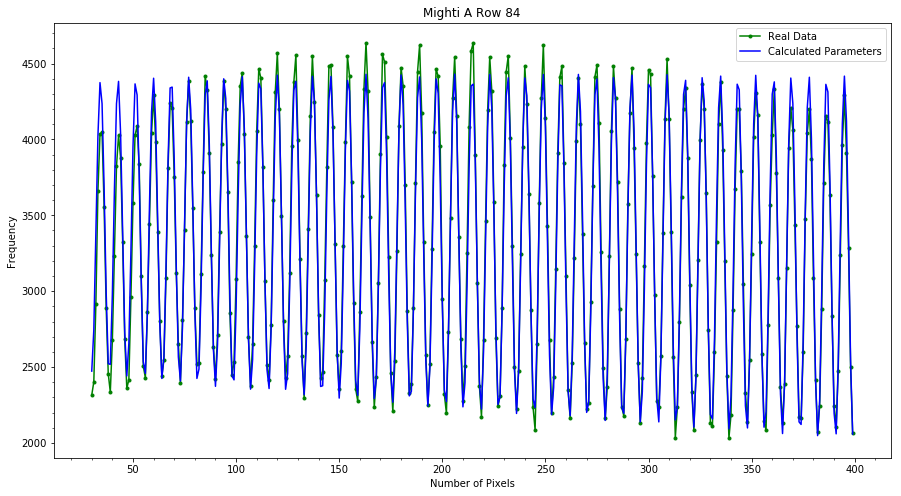

In [5]:
#Uncertainty in measurement
unc = np.sqrt(SimpRow[pix-30])

#Initial Guess Parameters
initial = [-10, 3/4, 6, 1, np.mean(SimpRow)/1000, .01, 1.4]

#The Upper and lower limits of each parameter, inf means none (infinity)
bounds = ([-100, initial[1]*0.5, initial[2]*-2.0, 
           0, initial[4]*0.5, 0, 0], 
          
           [100, initial[1]*1.5, initial[2]*2.0,
            np.inf, initial[4]*1.5, initial[5]*1.5, initial[6]*2.0])

#Paramfitcheck prints out a formatted output and returns things seperately
stuff = paramfitcheck(pix, SimpRow, CompFunc, unc, initial, bounds)

#This isolates just the parameters
params = stuff[0] 

#Now to Check the Initial Conditions and the Graph Fit using the forward function 
GraphCheck = CompFunc(pix, params[0], params[1], params[2], params[3], params[4], params[5], params[6])
InitialCheck = CompFunc(pix, initial[0], initial[1], initial[2], initial[3], initial[4], initial[5], initial[6])

#Graphing Stuff
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(15, 8)

#This provides a zoomed in look at the data
###ax.plot(pix[100:200], SimpRow[100:200], 'g.-', label = 'Real Data Zoomed')
###ax.plot(pix[100:200], GraphCheck[100:200], 'b-', label = 'Calculated Parameters Zoomed')

#Actual Graphing
ax.plot(pix, SimpRow, 'g.-', label = 'Real Data')
ax.plot(pix, GraphCheck, 'b-', label = 'Calculated Parameters')

#I also graphed the guess parameters to see if I was close to data to start
###ax.plot(pix, InitialCheck, 'k-', label = 'Guess Parameters')
ax.legend(loc='best')
ax.minorticks_on()
ax.set_xlabel('Number of Pixels')
ax.set_ylabel('Frequency')
ax.set_title('Mighti A Row {}'.format(row))


## Step Five

I noticed that some rows had really small $\chi^2$ around or below 5 but others were over 300!

I decided to graph all of the $\chi^2$ against row number.

**This block of code is slow (90 seconds or so) since it is trying to perform 90 fits**

In [6]:
AllChisq = np.zeros(87)
count = 0

for i in range(87):
    count = count + 1
    SimpRow2 = np.array(rdata[i][30:400])
    unc2 = np.sqrt(SimpRow2[pix - 30])
    initial = [20, 3/4, 60, 50, np.mean(SimpRow2)/1000, .1, 1.4]
    bounds = ([-np.inf, initial[1]*0.5, initial[2]*-2.0, 
           -np.inf, initial[4]*0.1, -np.inf, -initial[6]*2], 
          
           [np.inf, initial[1]*1.5, initial[2]*2.0,
            np.inf, initial[4]*1.5, np.inf, initial[6]*2.0])
    
    stuff2 = paramfitcheck(pix, SimpRow2, CompFunc, unc2, initial, bounds)
    params = stuff2[0] 
    AllChisq[i] = stuff2[2]/stuff2[3]


## Step Five B

With all of the ugly output above (which could be suppressed but did actually turn out to be useful), it was easier to plot the graph below. 

Notice that while the $\chi^2$ is quite small for some regions, there are unexpected spikes **not attributable to edge effects**

These spikes are caused by slight modifications to bounds and parameters, as shown below. 

(array([ 1,  2,  3,  4,  5,  6, 21, 45, 46, 47, 48, 60, 71, 72, 79], dtype=int64),)
15
Number of Rows Checked Before Error= 86


10.349893845394092

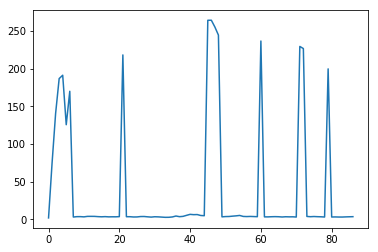

In [7]:
plt.plot(np.arange(0, 87), AllChisq)
print(np.where(AllChisq>10))
print( np.size(np.where(AllChisq > 10)))
print ('Number of Rows Checked Before Error=', count-1)
np.mean(AllChisq[7:39])

## Step Six

Analyzing the issue is simple enough. I just looked for where the $\chi^2$ was larger than 10 and picked a row at random to graph versus a nearby normal row. The graph below shows how similar the data sets are. The only obvious differences are in phase and starting position. 

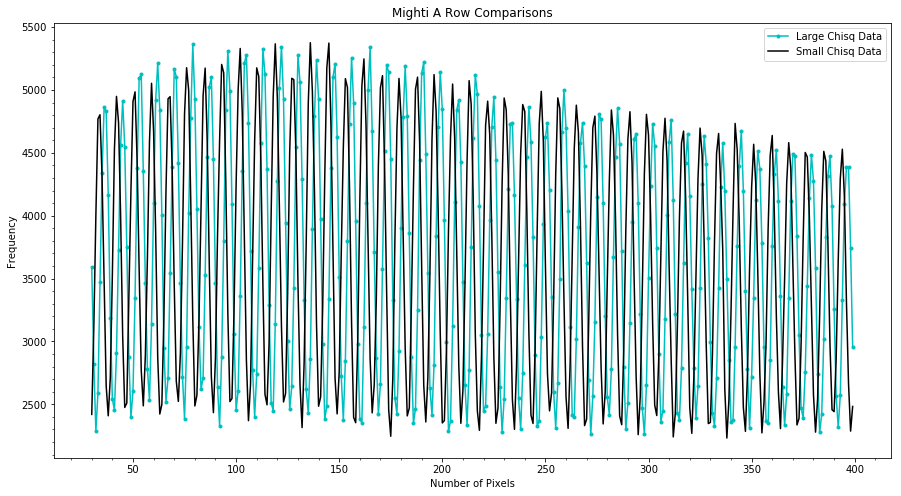

In [8]:
ROI = 45
weirdRow = np.array(rdata[ROI][30:400])
normRow = np.array(rdata[35][30:400])

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(15, 8)
ax.plot(pix, weirdRow, 'c.-', label = 'Large Chisq Data')
ax.plot(pix, normRow, 'k-', label = 'Small Chisq Data')
ax.legend(loc='best')
ax.minorticks_on()
ax.set_xlabel('Number of Pixels')
ax.set_ylabel('Frequency')
ax.set_title('Mighti A Row Comparisons')



## Step Six B

As noted above, the data look similar for both rows. So next lets look at the fits and redo the optimization for just these two rows and compare what the fits and parameters look like. 

If a parameter is markedly different between the two, this could give a clue as to a bound to fix or rewriting the forward function with a new parameter. Alternatively, it could be an initial value problem, which is also tested below. 


In [9]:
Normunc = np.sqrt(normRow[pix - 30])
Weirdunc = np.sqrt(weirdRow[pix - 30])

Ninitial = [100, 3/4, 6, 1, np.mean(normRow)/1000, .01, 1.4]
Winitial = [100, 3/4, 6, 1, np.mean(weirdRow)/1000, .01, 1.4]



Nbounds = ([-100, Ninitial[1]*0.5, Ninitial[2]*-2.0, 
           -np.inf, Ninitial[4]*0.5, 0, Ninitial[6]*-2.0], 
           
           [101,  Ninitial[1]*1.5, Ninitial[2]*2.0,
            np.inf, Ninitial[4]*1.5, Ninitial[5]*1.5, Ninitial[6]*2.0])

Wbounds = ([-100, Winitial[1]*0.5, Winitial[2]*-2.0, 
           -np.inf, Winitial[4]*0.5, 0, Winitial[6]*-2.0], 
           
           [101, Winitial[1]*1.5, Winitial[2]*2.0,
            np.inf, Winitial[4]*1.5, Winitial[5]*1.5, Winitial[6]*2.0])

print("""First a fit with handfit initial parameters""")

Normstuff = paramfitcheck(pix, normRow, CompFunc, Normunc, Ninitial, Nbounds)
Weirdstuff = paramfitcheck(pix, weirdRow, CompFunc, Weirdunc, Winitial, Wbounds)

Normparams = Normstuff[0]
Weirdparams = Weirdstuff[0]




Ninitial2 = [20, 3/4, 60, 50, np.mean(normRow)/1000, .1, 1.4]
Winitial2 = [20, 3/4, 60, 50, np.mean(weirdRow)/1000, .1, 1.4]

Nbounds2 = ([-np.inf, Ninitial2[1]*0.5, Ninitial2[2]*-2.0, 
           -np.inf, Ninitial2[4]*0.1, -np.inf, Ninitial2[6]*-2], 
          
           [np.inf, Ninitial2[1]*1.5, Ninitial2[2]*2.0,
            np.inf, Ninitial2[4]*1.5, np.inf, Ninitial2[6]*2.0])

Wbounds2 = ([-np.inf, Winitial2[1]*0.5, Winitial2[2]*-2.0, 
           -np.inf, Winitial2[4]*0.1, -np.inf, Winitial2[6]*-2], 
          
           [np.inf, Winitial2[1]*1.5, Winitial2[2]*2.0,
            np.inf, Winitial2[4]*1.5, np.inf, Winitial2[6]*2.0])


print("""

Here is a fit using the parameters used for the previous loop

""")

Normstuff2 = paramfitcheck(pix, normRow, CompFunc, Normunc, Ninitial2, Nbounds2)
Weirdstuff2 = paramfitcheck(pix, weirdRow, CompFunc, Weirdunc, Winitial2, Wbounds2)

Normparams2 = Normstuff2[0]
Weirdparams2 = Weirdstuff2[0]

First a fit with handfit initial parameters


Here is a fit using the parameters used for the previous loop




## Step Six C

Graphing the parameters with the forward function gives a better visual standard for understading what the results mean. 

In this case, it seems like the initial conditions that work for all nearly all rows are quite poor at optimizing all the rows, as even when given up 6000 function calls, the curve_fit function gets stuck at $\chi^2 = 264$. 


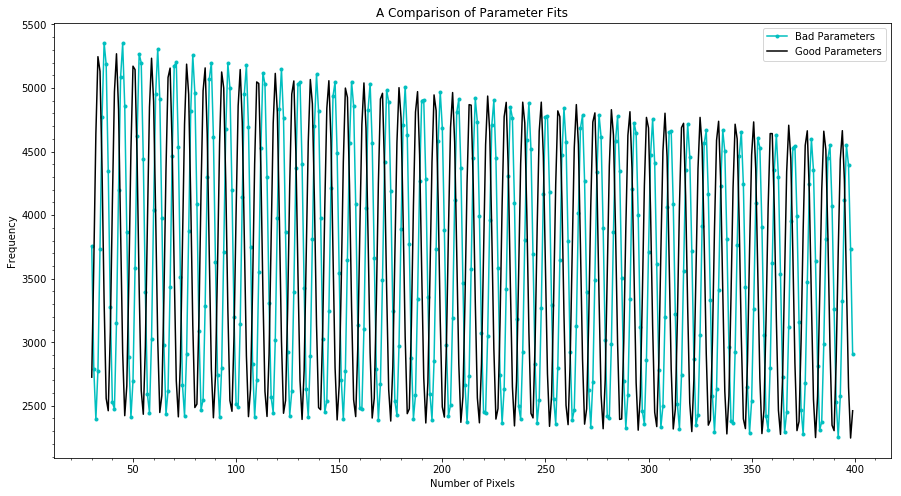

In [10]:
WeirdGraphCheck = CompFunc(pix, Weirdparams[0], Weirdparams[1], Weirdparams[2], Weirdparams[3], Weirdparams[4], 
                           Weirdparams[5], Weirdparams[6])
NormGraphCheck = CompFunc(pix, Normparams[0], Normparams[1], Normparams[2], Normparams[3], Normparams[4], 
                          Normparams[5], Normparams[6])

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(15, 8)
ax.plot(pix, WeirdGraphCheck, 'c.-', label = 'Bad Parameters')
ax.plot(pix, NormGraphCheck, 'k-', label = 'Good Parameters')
ax.legend(loc='best')
ax.minorticks_on()
ax.set_xlabel('Number of Pixels')
ax.set_ylabel('Frequency')
ax.set_title('A Comparison of Parameter Fits')

This next section is just more graphing, just showing what it looks like when $\chi^2$ is large. Normally the function either moves to zero amplitude in an attempt to 'average' the spikes in the function, or it starts very thin and spreads out with an large driving value over pixel space.  

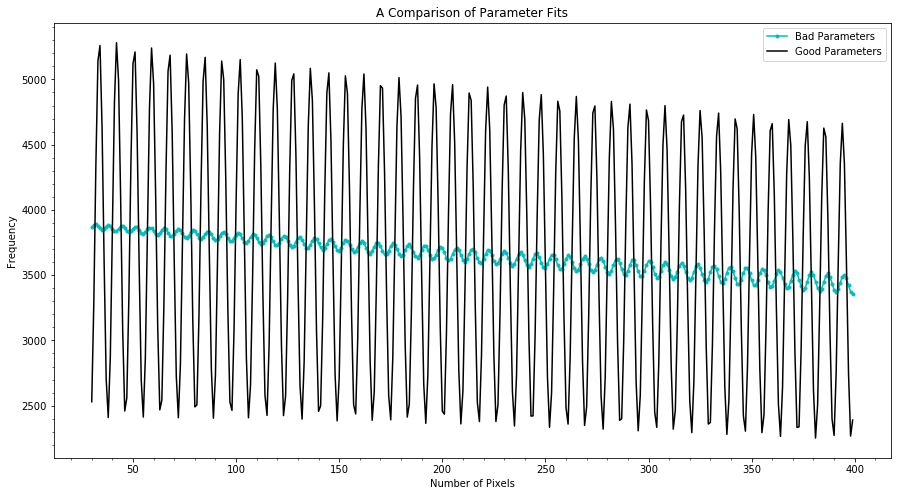

In [11]:
WeirdGraphCheck2 = CompFunc(pix, Weirdparams2[0], Weirdparams2[1], Weirdparams2[2], Weirdparams2[3], Weirdparams2[4], 
                           Weirdparams2[5], Weirdparams2[6])
NormGraphCheck2 = CompFunc(pix, Normparams2[0], Normparams2[1], Normparams2[2], Normparams2[3], Normparams2[4], 
                          Normparams2[5], Normparams2[6])

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(15, 8)
ax.plot(pix, WeirdGraphCheck2, 'c.-', label = 'Bad Parameters')
ax.plot(pix, NormGraphCheck2, 'k-', label = 'Good Parameters')
ax.legend(loc='best')
ax.minorticks_on()
ax.set_xlabel('Number of Pixels')
ax.set_ylabel('Frequency')
ax.set_title('A Comparison of Parameter Fits')

## Step 7 (Part Two of Notch Position Solving)

While being somewhat stuck on what was causing such large spikes in the $\chi^2$ , I decided to move on with my forward model to try and fit the fringe peaks in the notch rows with the same forward function. 

*The only reason to copy the functions below is for reference, except that calculated phase change does **not** work in this implementation due to its size. Luckily, the phase change for the edge rows is zero anyway*

I decided to edit the fit function slightly to not print out any statements, as a loop is required to remove the notch areas and fit the noNotch areas and the parameter information is less valuable here. The fitting algorithm requires more data points than paramaters when fitting a region, so I interpolated the curve and populated it with 10,000 points over the same range. *This should be checked for autocorrelation, but it was the easiest way to get the curve fit algorithm to still run.* 

The initial conditions were chosen mostly by hand, but could definitely still use some tweaking. 

This block outputs the \$chi^2$ for each small fit done and a small plot of what the row with notches looks like pre-fitting. 

[  3.88911919e+01   9.88116690e+01   3.86785236e+01   3.12235632e+01
   9.71371529e+01   4.88318164e+01   6.41008620e+01   1.15373123e+02
   5.77006276e+01   6.30772652e+01   1.16186907e+02   3.20041756e-04
   4.89625871e+01   3.24946035e-03   8.09170235e+01   9.12936930e+01
   6.38408582e+01   8.38434237e+01   6.94807488e+01   5.29435378e-02
   2.54997617e+01   7.93476730e+01   7.70566320e+01   5.08987747e+00
   1.57056416e+01   7.76237654e+01   6.40647382e+01   1.96019544e+01
   8.88723678e-01   6.50926100e+01   2.80596222e+01]


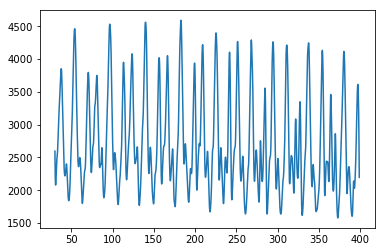

In [12]:
#Just Copied two below for reference, no changes
def AmpFunc(x, a1, a8):
    return a1*x**0.5 + a8 * 1000 #a2* x**0.25

def OffFunc(x, a5, a6):
    return -a5 * x + a6 * 1000

#Can't have phaseshift data with diff size arrays to be fitted
def TempCompFunc(x, a1, a3, a4, a5, a6, a7, a8):
    return  np.sin(a3 * x + a4*x**a7) * AmpFunc(x, a1, a8) +OffFunc(x, a5, a6)


#Just need a barebones param fit that won't print for a for loop
def QuietFit(x, y, func, unc, pguess, limit):
    (p, C) = opt.curve_fit(func, x, y, p0 = pguess, bounds = limit, check_finite = False, maxfev = 4000)#, absolute_sigma=True)
    sigma_p = np.sqrt(np.diag(C))
    chisq = np.sum((y - func(x, *p))**2 / unc ** 2)
    dof = len(y) - len(p)
                  
    return p, sigma_p, chisq, dof


CompRow = rdata[3][30:400]
line = interp.InterpolatedUnivariateSpline(pix, CompRow)
subpix = np.linspace(30, 399, 10000)
IntCompRow = line(subpix) 
checker = 0 
tinitial = [1, .6, .2, 1, 3, .01, 1.6]
tempBounds = ([-100, tinitial[1]*0.8, tinitial[2]*-20.0, 
           -np.inf, tinitial[4]*0.8, 0, tinitial[6]*0.5], 
           
           [100, tinitial[1]*1.2, tinitial[2]*20.0,
            np.inf, tinitial[4]*1.5, tinitial[5]*5, tinitial[6]*1.1])
ParamArray = np.array([])
ChisqArray = np.array([])
CheckerArray = np.array([])

for index in range(np.size(IntCompRow)):
    if IntCompRow[index] < 2700:
        if checker != 0:
            tXAxis = np.arange(index-checker, index)
            rangey = IntCompRow[index-checker:index]
            quietStuff = QuietFit(tXAxis, rangey, TempCompFunc, 
                                  np.sqrt(rangey[0:]), tinitial, tempBounds)
            TempParams = quietStuff[0]
            TempChisq = quietStuff[2]/quietStuff[3]
            ParamArray = np.append(ParamArray, TempParams)
            ChisqArray = np.append(ChisqArray, TempChisq)
            CheckerArray = np.append(CheckerArray, [index - checker, index])
        checker = 0
    else:
        checker += 1




plt.plot(subpix, IntCompRow)

print(ChisqArray)


## <font color='blue'>Step 8</font>
Now that the fit has been applied and the information about each fit has been stored in a few arrays, the parameters need to assigned to each fit/pixel region and plugged into the function. This requires another for loop. While just one could have been used, this method imoproves readability and obviously allows for analysis/sanity checks between assignment and use. 

*These variable names (and nearly all in this code) are temporary and will be changed to match global parameters and to be (hopefully) easier to differentiate.*



In [13]:
BigChoppyXAxis = np.array([])
BigGraphCheck = np.array([])
for i in range(np.size(CheckerArray)//2):
    start = int(CheckerArray[2*i])
    stop = int(CheckerArray[2*i + 1])
    ChoppyXAxis = subpix[start:stop]
    BigGraphCheck = np.append(BigGraphCheck, TempCompFunc(ChoppyXAxis, ParamArray[0 +7*i], ParamArray[1 + 7*i], 
                                 ParamArray[2 + 7*i], ParamArray[3 + 7*i], ParamArray[4 + 7*i], 
                                 ParamArray[5 + 7*i], ParamArray[6 + 7*i]))
    BigChoppyXAxis = np.append(BigChoppyXAxis, ChoppyXAxis)

BigInitialCheck = TempCompFunc(subpix, tinitial[0], tinitial[1], tinitial[2], tinitial[3], tinitial[4],
                              tinitial[5], tinitial[6])

## Step 9 

Now to graph the fit of the notch areas vs the initial conditions and the actual data. 


**The initial curve looks pretty good for the areas with no notches, but the fit is awful. Currently stuck here as to why, as it does not seem to be a bounds issue. Could be the scale or the lack of 'real' data points, see autocorrelation note above**

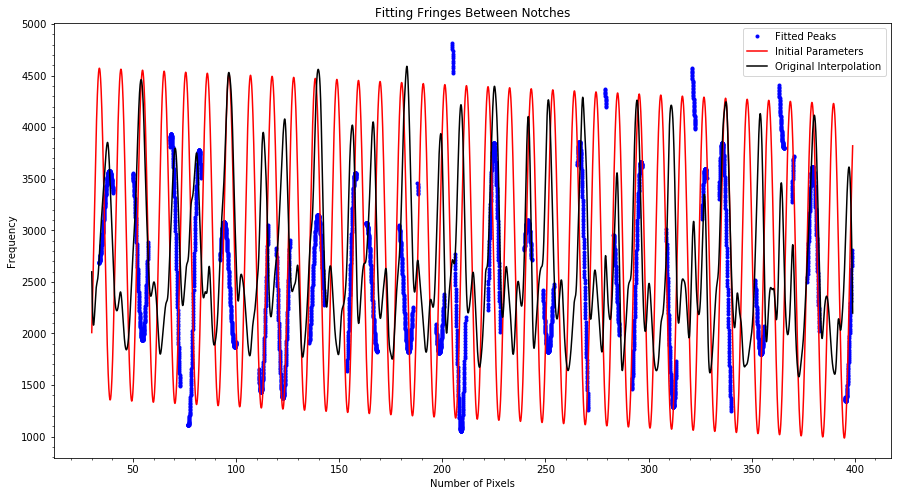

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(15, 8)
ax.plot(BigChoppyXAxis, BigGraphCheck, 'b.', label = 'Fitted Peaks')
ax.plot(subpix, BigInitialCheck, 'r', label = 'Initial Parameters')
ax.plot(subpix, IntCompRow, 'k-', label = 'Original Interpolation')
ax.legend(loc='best')
ax.minorticks_on()
ax.set_xlabel('Number of Pixels')
ax.set_ylabel('Frequency')
ax.set_title('Fitting Fringes Between Notches')

### Random Code Snippet
This piece of code simply allows me to isolate the parameters for one particular fit and look at them to try and understand why they don't match the initial conditions. 

$ f = (a_1*x^{1/2} + a_8*1000) * sin(a_3 * x + a_4 * x^{a_7} + \psi) + a_6 * 1000 - a_8*x $ 

In [15]:
fitnum = 1
print (ParamArray[0::7][fitnum])
print (ParamArray[1::7][fitnum])
print (ParamArray[2::7][fitnum])
print (ParamArray[3::7][fitnum])
print (ParamArray[4::7][fitnum])
print (ParamArray[5::7][fitnum])
print (ParamArray[6::7][fitnum])

-46.1937505199
0.609765140928
-3.23418312308
-1.56950688421
2.67093320751
0.0135423761993
1.16163612098
